# Problem Setup

## 1. Problem Statement
We are investigating the trade-off between **Convex Relaxation (QP)** and **Non-Convex Differentiable Physics (PyTorch)** in the context of battery energy arbitrage.

The core engineering challenge is to determine which error source is more detrimental to real-world performance:
1.  **The Optimality Gap:** The error introduced by simplifying non-linear battery physics (e.g., efficiency curves) to make the problem convex and solvable by QP.
2.  **The Convergence Error:** The error introduced by the instability of gradient descent when optimizing a non-convex, constrained landscape in PyTorch.

Our goal is to implement a "Differentiable Battery" model that can learn arbitrage strategies (buy low, sell high) purely via gradient descent, while strictly respecting physical constraints.

---

## 2. Mathematical Formulation

We model the battery optimization as a profit maximization problem over a time horizon $T$ (e.g., $T=8760$ hours).

### Objective Function
We aim to maximize the total profit $J$, defined as arbitrage revenue minus a degradation penalty.

$$
\text{Maximize } J = \sum_{t=1}^{T} \Big( \underbrace{P_t (d_t - c_t)}_{\text{Revenue}} - \underbrace{\lambda (c_t + d_t)^2}_{\text{Degradation Penalty}} \Big)
$$

Where:
* $P_t$: Electricity Price (LMP) at time $t$ [$/MWh]
* $d_t$: Discharge amount at time $t$ [MW]
* $c_t$: Charge amount at time $t$ [MW]
* $\lambda$: Degradation coefficient (regularization term)

### System Dynamics (The State Equation)
The battery State of Charge ($SoC$) evolves according to:

$$
SoC_{t+1} = SoC_t + \eta_{c} c_t - \frac{1}{\eta_{d}} d_t
$$

Where:
* $\eta_{c}, \eta_{d}$: Charge and Discharge efficiency coefficients (typically $0.95$).

### Constraints
The system must strictly satisfy the following hard constraints at every step $t$:

1.  **Capacity Limits:** $0 \le SoC_t \le SoC_{max}$
2.  **Power Limits:** $0 \le c_t \le P_{max}$ and $0 \le d_t \le P_{max}$
3.  **Non-Simultaneity:** A battery cannot charge and discharge effectively at the same time (handled implicitly by the cost function or explicitly via complementarity constraints).

---

## 3. Data Requirements

To benchmark this effectively, we rely on historical Locational Marginal Pricing (LMP) data.

* **Source:** PJM Interconnection (via `gridstatus` or Data Miner 2).
* **Target Node:** PECO Zone (Philadelphia), Node ID `51298`.
* **Resolution:** Hourly (1-hour intervals).
* **Horizon:** One full year ($T=8760$ steps) to capture seasonal volatility.
* **Features Needed:**
    * `Total LMP` ($P_t$): The input signal for our optimization.
    * `Time`: For indexing and visualization.

---

## 4. Success Metrics

We will evaluate the models based on three key criteria:

1.  **Behavorial Validity (The "Eye Test"):**
    * Does the model learn to charge when $P_t$ is low and discharge when $P_t$ is high?
    * Does it avoid "churning" (needless cycling) due to the degradation penalty?

2.  **Physical Feasibility (Constraint Satisfaction):**
    * **Violation Rate:** What percentage of time steps does the model violate $0 \le SoC \le SoC_{max}$?
    * **Magnitude:** If violations occur, how large are they (e.g., $SoC = -0.5$ vs $SoC = -50$)?

3.  **Financial Performance:**
    * **Total Profit ($):** The cumulative objective value over the test horizon.
    * **Optimality Gap:** How close is the PyTorch solution to the theoretical upper bound provided by the QP solver?

In [1]:
import gridstatus
import pandas as pd
import time
import tracemalloc
import torch
import numpy as np
import matplotlib.pyplot as plt
import gridstatus
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

### Implementation

Fetching NYISO Data...
Data Loaded: 259 intervals (5-min resolution) for N.Y.C.
Average Price: $214.58/MWh

Starting Optimization...
Epoch 0: Profit = $0.00 | Violations = 0
Epoch 100: Profit = $97.71 | Violations = 0
Epoch 200: Profit = $101.97 | Violations = 0
Epoch 300: Profit = $106.44 | Violations = 0
Epoch 400: Profit = $-23.38 | Violations = 0
Epoch 500: Profit = $114.60 | Violations = 0
Epoch 600: Profit = $24.39 | Violations = 0
Epoch 700: Profit = $131.68 | Violations = 0
Epoch 800: Profit = $93.05 | Violations = 0
Epoch 900: Profit = $124.89 | Violations = 0

Optimization Complete.


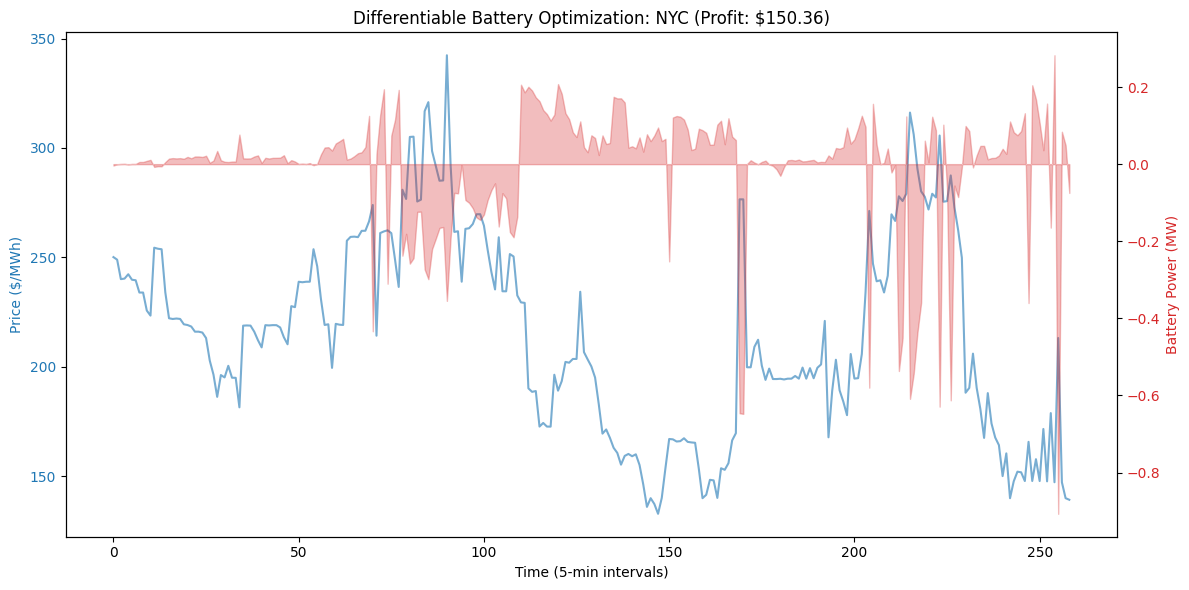

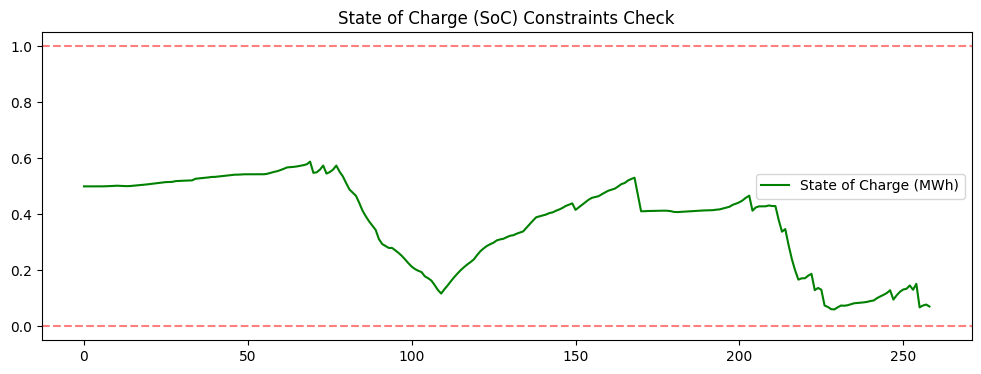

In [2]:

# --- 1. DATA INGESTION ---
print("Fetching NYISO Data...")
iso = gridstatus.NYISO()
df = iso.get_lmp(date="today", market="REAL_TIME_5_MIN", locations="ALL")

# Filter for N.Y.C. Zone
df_nyc = df[df['Location'] == 'N.Y.C.'].copy()
df_nyc = df_nyc.sort_values('Time').reset_index(drop=True)

# Extract Price ($/MWh)
prices = torch.tensor(df_nyc['LMP'].values, dtype=torch.float32)
T = len(prices)

print(f"Data Loaded: {T} intervals (5-min resolution) for N.Y.C.")
print(f"Average Price: ${prices.mean().item():.2f}/MWh")

# --- 2. THE DIFFERENTIABLE BATTERY MODEL ---
class DifferentiableBattery(nn.Module):
    def __init__(self, horizon_len, capacity_mwh=1.0, power_mw=1.0, efficiency=0.9):
        super().__init__()
        self.horizon_len = horizon_len
        self.capacity = capacity_mwh
        self.max_power = power_mw
        self.eta = efficiency
        
        # PARAMETER: The control actions (Charge/Discharge)
        # We initialize them as 0.0. They are what we want to "learn".
        self.actions = nn.Parameter(torch.zeros(horizon_len, requires_grad=True))

    def forward(self):
        # Apply Power Constraints (Hard Tanh to squash between -1 and 1, then scale)
        control = torch.tanh(self.actions) * self.max_power
        
        # Simulate Physics (SoC Evolution)
        # Split control into charge (positive) and discharge (negative)
        charge_power = torch.relu(control)
        discharge_power = torch.relu(-control)
        
        # Energy change per step: MW * (5/60) hours
        dt = 5.0 / 60.0 
        
        # Efficiency Logic:
        delta_e = (charge_power * self.eta - discharge_power / self.eta) * dt
        
        # Cumulative Sum to get SoC profile
        soc_profile = torch.cumsum(delta_e, dim=0)
        
        # Assume starting SoC is 50%
        initial_soc = 0.5 * self.capacity
        soc_profile = soc_profile + initial_soc
        
        return control, soc_profile

# --- OPTIMIZATION LOOP ---
model = DifferentiableBattery(horizon_len=T)
optimizer = optim.Adam(model.parameters(), lr=0.1) 

EPOCHS = 1000
penalty_coeff = 2000.0 

print("\nStarting Optimization...")

for i in range(EPOCHS):
    optimizer.zero_grad()
    
    control, soc = model()
    
    # --- REVENUE CALCULATION ---
    # Formula: -(-1) * Price = +Price (Revenue)
    dt = 5.0 / 60.0
    daily_revenue = torch.sum(-control * prices * dt)
    
    # --- CONSTRAINTS ---
    # Penalize if SoC goes below 0 or above Capacity
    soc_violation = torch.relu(-soc) + torch.relu(soc - model.capacity)
    constraint_loss = torch.sum(soc_violation) * penalty_coeff

    # --- LOSS FUNCTION  ---
    # We want to MAXIMIZE Revenue, so we MINIMIZE Negative Revenue.
    # We also minimize the constraint penalty.
    loss = -daily_revenue + constraint_loss
    
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(f"Epoch {i}: Profit = ${daily_revenue.item():.2f} | Violations = {torch.sum(soc_violation > 0).item()}")

# --- VISUALIZATION ---
print("\nOptimization Complete.")

final_control, final_soc = model()
actions_np = final_control.detach().numpy()
soc_np = final_soc.detach().numpy()
prices_np = prices.numpy()

fig, ax1 = plt.subplots(figsize=(12, 6))

# Plot Prices
ax1.set_xlabel('Time (5-min intervals)')
ax1.set_ylabel('Price ($/MWh)', color='tab:blue')
ax1.plot(prices_np, color='tab:blue', alpha=0.6, label='LMP Price')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot Actions (Bar chart)
ax2 = ax1.twinx()
ax2.set_ylabel('Battery Power (MW)', color='tab:red')

# Positive = Charge (Red Up), Negative = Discharge (Red Down)
ax2.fill_between(range(T), actions_np, color='tab:red', alpha=0.3, label='Charge/Discharge')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title(f"Differentiable Battery Optimization: NYC (Profit: ${daily_revenue.item():.2f})")
fig.tight_layout()
plt.show()

# Plot SoC Check
plt.figure(figsize=(12, 4))
plt.plot(soc_np, color='green', label='State of Charge (MWh)')
plt.axhline(y=0, color='r', linestyle='--', alpha=0.5)
plt.axhline(y=model.capacity, color='r', linestyle='--', alpha=0.5)
plt.title("State of Charge (SoC) Constraints Check")
plt.legend()
plt.show()

### Validation

=== STARTING VALIDATION SUITE ===

Running Test Case: Flat Prices ($50/MWh)
Expectation: Battery should stay idle (Action ~ 0).
   -> Final Profit: $9.30
   -> Max Constraint Violation: 0.0000
   -> Execution Time: 0.0813 sec
   -> Peak Memory: 0.02 MB

Running Test Case: Negative Prices (-$5 to -$10)
Expectation: Battery should CHARGE (Positive Action).
   -> Final Profit: $3.02
   -> Max Constraint Violation: 0.0000
   -> Execution Time: 0.0748 sec
   -> Peak Memory: 0.01 MB

Running Test Case: Single Price Spike
Expectation: Battery should DISCHARGE (Negative Action) at index 50.
   -> Final Profit: $32.16
   -> Max Constraint Violation: 0.0000
   -> Execution Time: 0.0761 sec
   -> Peak Memory: 0.01 MB


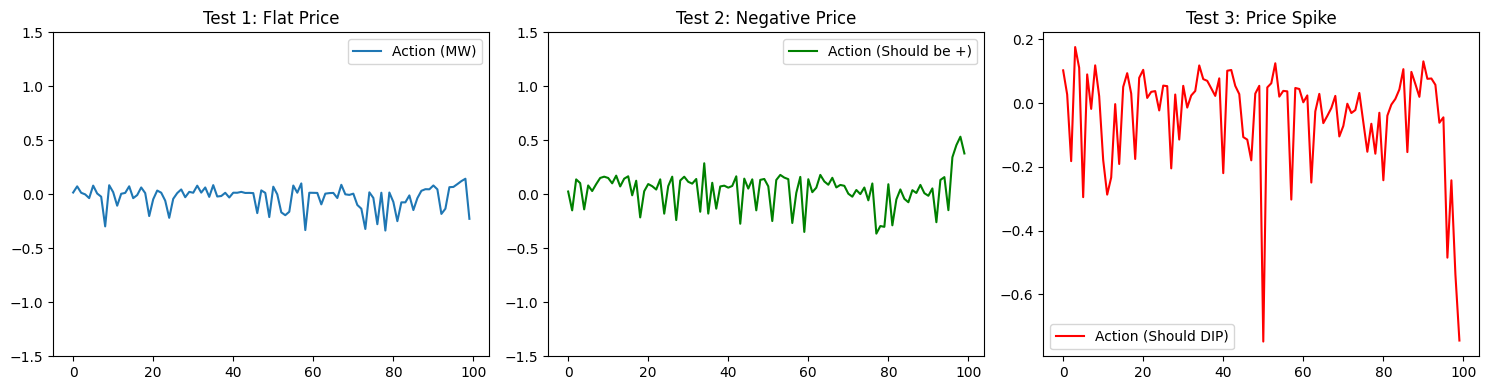

In [ ]:

# --- PERFORMANCE MONITORING UTILS ---
def measure_resources(func):
    def wrapper(*args, **kwargs):
        tracemalloc.start()
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()
        print(f"   -> Execution Time: {end_time - start_time:.4f} sec")
        print(f"   -> Peak Memory: {peak / 10**6:.2f} MB")
        return result
    return wrapper

# --- TEST CASE GENERATORS ---
def generate_flat_prices(length=100, price=50.0):
    return torch.full((length,), price)

def generate_negative_prices(length=100):
    # Prices vary between -10 and -5
    return torch.FloatTensor(length).uniform_(-10, -5)

def generate_spike_prices(length=100):
    p = torch.full((length,), 20.0)
    p[50] = 500.0 # Huge spike in middle
    return p

# --- VALIDATION RUNNER  ---
@measure_resources
def run_validation_case(name, prices, expected_behavior_desc):
    print(f"\nRunning Test Case: {name}")
    print(f"Expectation: {expected_behavior_desc}")
    
    # 1. Setup Model
    T = len(prices)
    model = DifferentiableBattery(horizon_len=T)
    
    # We overwrite the zeros with small random numbers
    with torch.no_grad():
        model.actions.copy_(torch.randn(T) * 0.1)
    
    optimizer = optim.Adam(model.parameters(), lr=0.1)
    
    # Train
    for _ in range(300): 
        optimizer.zero_grad()
        control, soc = model()
        
        # Split control
        charge_mw = torch.relu(control)
        discharge_mw = torch.relu(-control)
        dt = 5.0 / 60.0

        # Cost & Revenue
        cost = charge_mw * prices * dt
        revenue_from_grid = (discharge_mw * model.eta) * prices * dt
        
        daily_profit = torch.sum(revenue_from_grid - cost)
        
        # Constraints
        soc_violation = torch.relu(-soc) + torch.relu(soc - model.capacity)
        penalty = 2000 * torch.sum(soc_violation) 
        
        loss = -daily_profit + penalty
        
        loss.backward()
        optimizer.step()
        
    # Analyze Results
    control, soc = model()
    
    charge_mw = torch.relu(control)
    discharge_mw = torch.relu(-control)
    cost = charge_mw * prices * (5.0/60.0)
    rev = (discharge_mw * model.eta) * prices * (5.0/60.0)
    total_profit = torch.sum(rev - cost).item()
    
    max_violation = (torch.relu(-soc) + torch.relu(soc - model.capacity)).max().item()
    
    print(f"   -> Final Profit: ${total_profit:.2f}")
    print(f"   -> Max Constraint Violation: {max_violation:.4f}")
    
    return control.detach(), soc.detach()

# --- EXECUTE SUITE ---
print("=== STARTING VALIDATION SUITE ===")

# TEST 1: The "Flatline"
c_flat, s_flat = run_validation_case(
    "Flat Prices ($50/MWh)", 
    generate_flat_prices(), 
    "Battery should stay idle (Action ~ 0)."
)

# TEST 2: Negative Prices
c_neg, s_neg = run_validation_case(
    "Negative Prices (-$5 to -$10)", 
    generate_negative_prices(), 
    "Battery should CHARGE (Positive Action)."
)

# TEST 3: The "Spike"
c_spike, s_spike = run_validation_case(
    "Single Price Spike", 
    generate_spike_prices(), 
    "Battery should DISCHARGE (Negative Action) at index 50."
)

# --- VISUALIZE OUTPUTS ---
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot Flat
axs[0].set_title("Test 1: Flat Price")
axs[0].plot(c_flat, label="Action (MW)")
axs[0].set_ylim(-1.5, 1.5)
axs[0].legend()

# Plot Negative
axs[1].set_title("Test 2: Negative Price")
axs[1].plot(c_neg, color='green', label="Action (Should be +)")
axs[1].set_ylim(-1.5, 1.5)
axs[1].legend()

# Plot Spike
axs[2].set_title("Test 3: Price Spike")
axs[2].plot(c_spike, color='red', label="Action (Should DIP)")
axs[2].legend()

plt.tight_layout()
plt.show()